# GRPO Fine-Tuning Setup for VLM Object Counting

This notebook sets up the framework for GRPO (Group Relative Policy Optimization) fine-tuning using the HuggingFace TRL library.

## Reward Function Design

We implement a two-component reward function:

### 1. GradCAM Attention Map Similarity Reward
- Create an "ideal" attention map with Gaussian blobs centered on ground truth object centroids
- Extract the actual GradCAM attention map from the model
- Compute similarity between predicted and ideal attention maps
- Higher similarity = higher reward

### 2. Count Accuracy Reward
- Compare predicted count vs ground truth count
- Use inverse distance with offset to avoid division by zero
- Closer count = higher reward

## Reference
Based on: https://colab.research.google.com/github/huggingface/trl/blob/main/examples/notebooks/grpo_qwen3_vl.ipynb

In [1]:
import sys
sys.path.append('../src')

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from typing import List, Tuple, Dict
import json
import os

## 1. Ideal GradCAM Map Generation

Create an "ideal" attention map where:
- Each ground truth centroid has a Gaussian blob of attention
- Attention is highest at the centroid and falls off with distance
- All objects contribute equally to the ideal attention distribution

In [2]:
def create_ideal_gradcam(
    centroids: List[Tuple[int, int]],
    image_size: Tuple[int, int],
    sigma: float = 15.0,
    normalize: bool = True
) -> np.ndarray:
    """
    Create an ideal GradCAM attention map with Gaussian blobs at each centroid.
    
    Args:
        centroids: List of (x, y) coordinates for object centers
        image_size: (width, height) of the image
        sigma: Standard deviation of Gaussian blobs (controls spread)
        normalize: Whether to normalize to [0, 1] range
    
    Returns:
        ideal_map: 2D numpy array of shape (height, width) with attention values
    """
    width, height = image_size
    ideal_map = np.zeros((height, width), dtype=np.float32)
    
    # Create coordinate grids
    y_grid, x_grid = np.mgrid[0:height, 0:width]
    
    # Add Gaussian blob for each centroid
    for cx, cy in centroids:
        # Calculate distance from centroid
        distances_sq = (x_grid - cx)**2 + (y_grid - cy)**2
        
        # Create Gaussian blob
        gaussian_blob = np.exp(-distances_sq / (2 * sigma**2))
        
        # Add to ideal map (using max to handle overlapping objects)
        ideal_map = np.maximum(ideal_map, gaussian_blob)
    
    # Normalize to [0, 1] if requested
    if normalize and ideal_map.max() > 0:
        ideal_map = ideal_map / ideal_map.max()
    
    return ideal_map

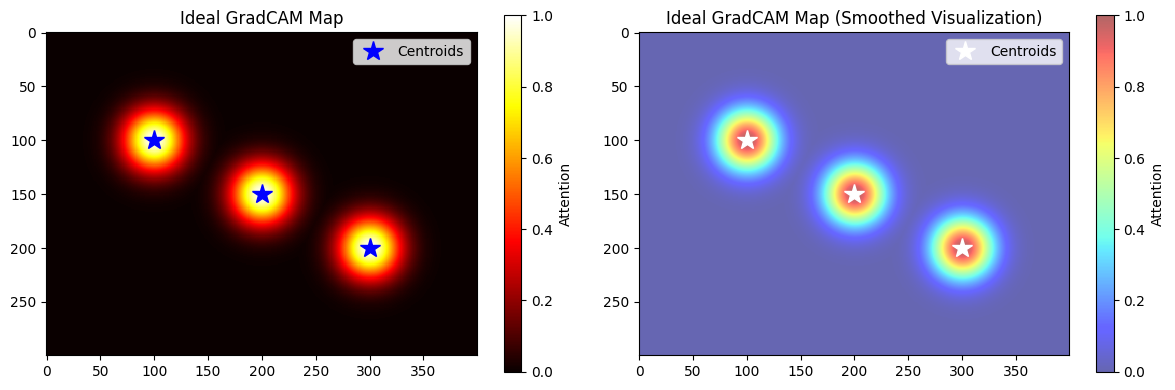

In [3]:
# Test ideal GradCAM generation
test_centroids = [(100, 100), (200, 150), (300, 200)]
test_size = (400, 300)

ideal_map = create_ideal_gradcam(test_centroids, test_size, sigma=20.0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(ideal_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Attention')
plt.plot([c[0] for c in test_centroids], [c[1] for c in test_centroids], 'b*', markersize=15, label='Centroids')
plt.title('Ideal GradCAM Map')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(ideal_map, cmap='jet', interpolation='bilinear', alpha=0.6)
plt.plot([c[0] for c in test_centroids], [c[1] for c in test_centroids], 'w*', markersize=15, label='Centroids')
plt.colorbar(label='Attention')
plt.title('Ideal GradCAM Map (Smoothed Visualization)')
plt.legend()

plt.tight_layout()
plt.show()

## 2. GradCAM Extraction from VLM

Extract actual attention maps from the VLM model during inference.

In [4]:
def extract_gradcam_from_vlm(
    model,
    processor,
    image: Image.Image,
    prompt: str,
    target_layer: str = None
) -> np.ndarray:
    """
    Extract GradCAM attention map from VLM model.
    
    Args:
        model: VLM model (e.g., Qwen3-VL)
        processor: Model processor
        image: Input PIL image
        prompt: Text prompt for counting
        target_layer: Layer to extract gradients from (if None, use last vision layer)
    
    Returns:
        gradcam_map: 2D numpy array of shape (height, width) with attention values
    """
    model.eval()
    
    # Prepare inputs
    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    ).to(model.device)
    
    # Register hooks to capture activations and gradients
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output.detach())
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())
    
    # Find target layer (default: last vision transformer layer)
    if target_layer is None:
        # For Qwen3-VL, typically the last vision encoder layer
        if hasattr(model, 'visual'):
            target = model.visual.transformer.resblocks[-1]
        elif hasattr(model, 'vision_model'):
            target = model.vision_model.encoder.layers[-1]
        else:
            raise ValueError("Could not find vision encoder in model")
    else:
        target = dict(model.named_modules())[target_layer]
    
    # Register hooks
    forward_handle = target.register_forward_hook(forward_hook)
    backward_handle = target.register_full_backward_hook(backward_hook)
    
    try:
        # Forward pass
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            output_attentions=True,
            return_dict_in_generate=True
        )
        
        # Get logits for the count prediction
        # We need to compute loss/gradient with respect to the output
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs.scores[0]
        
        # Compute gradient by backpropagating from output
        logits.mean().backward()
        
        # Compute GradCAM
        if len(activations) == 0 or len(gradients) == 0:
            raise ValueError("Failed to capture activations or gradients")
        
        # Get activation and gradient
        activation = activations[0]
        gradient = gradients[0]
        
        # Global average pooling of gradients
        weights = torch.mean(gradient, dim=(0, 1), keepdim=True)
        
        # Weighted combination of activation maps
        gradcam = torch.sum(weights * activation, dim=-1)
        
        # Apply ReLU (only positive influence)
        gradcam = torch.relu(gradcam)
        
        # Convert to numpy and resize to image size
        gradcam_np = gradcam.cpu().numpy().squeeze()
        
        # Resize to match image dimensions
        from scipy.ndimage import zoom
        h, w = image.size[1], image.size[0]
        zoom_factors = (h / gradcam_np.shape[0], w / gradcam_np.shape[1])
        gradcam_resized = zoom(gradcam_np, zoom_factors, order=1)
        
        # Normalize
        if gradcam_resized.max() > 0:
            gradcam_resized = gradcam_resized / gradcam_resized.max()
        
        return gradcam_resized
    
    finally:
        # Remove hooks
        forward_handle.remove()
        backward_handle.remove()

## 3. Alternative: Cluster Centroid Detection from GradCAM

As an alternative approach, detect N cluster centroids from the predicted GradCAM map and match them to ground truth objects.

In [5]:
def detect_centroids_from_gradcam(
    gradcam_map: np.ndarray,
    num_objects: int,
    threshold: float = 0.3,
    min_distance: int = 20
) -> List[Tuple[int, int]]:
    """
    Detect N cluster centroids from a GradCAM attention map.
    
    Args:
        gradcam_map: 2D attention map
        num_objects: Expected number of objects to find
        threshold: Minimum attention value to consider
        min_distance: Minimum distance between detected centroids
    
    Returns:
        centroids: List of (x, y) coordinates for detected object centers
    """
    from skimage.feature import peak_local_max
    
    # Find local maxima in attention map
    coordinates = peak_local_max(
        gradcam_map,
        min_distance=min_distance,
        threshold_abs=threshold,
        num_peaks=num_objects
    )
    
    # Convert to (x, y) format
    centroids = [(int(x), int(y)) for y, x in coordinates]
    
    return centroids


def match_centroids_to_ground_truth(
    predicted_centroids: List[Tuple[int, int]],
    ground_truth_centroids: List[Tuple[int, int]]
) -> Tuple[float, List[Tuple[int, int, float]]]:
    """
    Match predicted centroids to ground truth using Hungarian algorithm.
    
    Args:
        predicted_centroids: List of predicted (x, y) coordinates
        ground_truth_centroids: List of ground truth (x, y) coordinates
    
    Returns:
        total_distance: Sum of distances for all matches
        matches: List of (pred_idx, gt_idx, distance) tuples
    """
    from scipy.optimize import linear_sum_assignment
    
    if len(predicted_centroids) == 0 or len(ground_truth_centroids) == 0:
        return float('inf'), []
    
    # Build cost matrix (Euclidean distances)
    n_pred = len(predicted_centroids)
    n_gt = len(ground_truth_centroids)
    cost_matrix = np.zeros((n_pred, n_gt))
    
    for i, (px, py) in enumerate(predicted_centroids):
        for j, (gx, gy) in enumerate(ground_truth_centroids):
            cost_matrix[i, j] = np.sqrt((px - gx)**2 + (py - gy)**2)
    
    # Solve assignment problem
    pred_indices, gt_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate total distance and create match list
    matches = []
    total_distance = 0
    
    for pred_idx, gt_idx in zip(pred_indices, gt_indices):
        distance = cost_matrix[pred_idx, gt_idx]
        matches.append((pred_idx, gt_idx, distance))
        total_distance += distance
    
    # Add penalty for unmatched predictions or ground truths
    unmatched_pred = n_pred - len(pred_indices)
    unmatched_gt = n_gt - len(gt_indices)
    penalty = max(unmatched_pred, unmatched_gt) * 100  # Large penalty per unmatched object
    total_distance += penalty
    
    return total_distance, matches

## 4. Reward Function Components

Implement the two reward components that will be used for GRPO training.

In [6]:
def compute_gradcam_similarity_reward(
    predicted_gradcam: np.ndarray,
    ideal_gradcam: np.ndarray,
    metric: str = 'ssim'
) -> float:
    """
    Compute reward based on similarity between predicted and ideal GradCAM maps.
    
    Args:
        predicted_gradcam: Predicted attention map from model
        ideal_gradcam: Ideal attention map from ground truth
        metric: Similarity metric ('ssim', 'mse', 'correlation')
    
    Returns:
        reward: Similarity score in [0, 1] range (higher is better)
    """
    # Ensure same shape
    if predicted_gradcam.shape != ideal_gradcam.shape:
        from scipy.ndimage import zoom
        zoom_factors = (
            ideal_gradcam.shape[0] / predicted_gradcam.shape[0],
            ideal_gradcam.shape[1] / predicted_gradcam.shape[1]
        )
        predicted_gradcam = zoom(predicted_gradcam, zoom_factors, order=1)
    
    if metric == 'ssim':
        # Structural Similarity Index
        from skimage.metrics import structural_similarity
        similarity = structural_similarity(
            ideal_gradcam,
            predicted_gradcam,
            data_range=1.0
        )
        # SSIM is in [-1, 1], convert to [0, 1]
        reward = (similarity + 1) / 2
    
    elif metric == 'mse':
        # Mean Squared Error (lower is better, so invert)
        mse = np.mean((predicted_gradcam - ideal_gradcam) ** 2)
        # Convert to reward (max possible MSE is 1.0 for normalized maps)
        reward = 1.0 / (1.0 + mse)
    
    elif metric == 'correlation':
        # Pearson correlation coefficient
        pred_flat = predicted_gradcam.flatten()
        ideal_flat = ideal_gradcam.flatten()
        correlation = np.corrcoef(pred_flat, ideal_flat)[0, 1]
        # Correlation is in [-1, 1], convert to [0, 1]
        reward = (correlation + 1) / 2
    
    else:
        raise ValueError(f"Unknown metric: {metric}")
    
    return float(reward)


def compute_count_accuracy_reward(
    predicted_count: int,
    ground_truth_count: int,
    offset: float = 10.0
) -> float:
    """
    Compute reward based on count accuracy.
    
    Args:
        predicted_count: Predicted object count
        ground_truth_count: Ground truth object count
        offset: Offset to avoid division by zero (higher = more forgiving)
    
    Returns:
        reward: Count accuracy reward (higher is better)
    """
    error = abs(predicted_count - ground_truth_count)
    reward = 1.0 / (error + offset)
    return float(reward)


def compute_centroid_matching_reward(
    predicted_centroids: List[Tuple[int, int]],
    ground_truth_centroids: List[Tuple[int, int]],
    image_size: Tuple[int, int],
    offset: float = 10.0
) -> float:
    """
    Compute reward based on centroid matching (alternative to GradCAM similarity).
    
    Args:
        predicted_centroids: List of predicted object centers
        ground_truth_centroids: List of ground truth object centers
        image_size: (width, height) for normalization
        offset: Offset to avoid division by zero
    
    Returns:
        reward: Centroid matching reward (higher is better)
    """
    total_distance, matches = match_centroids_to_ground_truth(
        predicted_centroids,
        ground_truth_centroids
    )
    
    # Normalize by image diagonal
    diagonal = np.sqrt(image_size[0]**2 + image_size[1]**2)
    normalized_distance = total_distance / diagonal
    
    # Convert to reward
    reward = 1.0 / (normalized_distance + offset)
    return float(reward)

## 5. Combined Reward Function

Combine the two reward components with configurable weights.

In [7]:
def compute_combined_reward(
    predicted_gradcam: np.ndarray,
    ideal_gradcam: np.ndarray,
    predicted_count: int,
    ground_truth_count: int,
    gradcam_weight: float = 0.6,
    count_weight: float = 0.4,
    gradcam_metric: str = 'ssim',
    count_offset: float = 10.0
) -> Dict[str, float]:
    """
    Compute combined reward from GradCAM similarity and count accuracy.
    
    Args:
        predicted_gradcam: Predicted attention map
        ideal_gradcam: Ideal attention map from ground truth
        predicted_count: Predicted object count
        ground_truth_count: Ground truth object count
        gradcam_weight: Weight for GradCAM similarity component
        count_weight: Weight for count accuracy component
        gradcam_metric: Metric for GradCAM similarity
        count_offset: Offset for count accuracy reward
    
    Returns:
        reward_dict: Dictionary with individual and combined rewards
    """
    # Compute individual rewards
    gradcam_reward = compute_gradcam_similarity_reward(
        predicted_gradcam,
        ideal_gradcam,
        metric=gradcam_metric
    )
    
    count_reward = compute_count_accuracy_reward(
        predicted_count,
        ground_truth_count,
        offset=count_offset
    )
    
    # Combine with weights
    combined_reward = gradcam_weight * gradcam_reward + count_weight * count_reward
    
    return {
        'gradcam_reward': gradcam_reward,
        'count_reward': count_reward,
        'combined_reward': combined_reward,
        'gradcam_weight': gradcam_weight,
        'count_weight': count_weight
    }

## 6. Test Reward Functions

Test the reward functions with synthetic data to verify they work as expected.

In [9]:
# Create test data
test_size = (400, 300)
gt_centroids = [(100, 100), (200, 150), (300, 200)]
gt_count = len(gt_centroids)

# Create ideal GradCAM
ideal_gradcam = create_ideal_gradcam(gt_centroids, test_size, sigma=20.0)

# Test Case 1: Perfect prediction
print("Test Case 1: Perfect Prediction")
print("="*60)
predicted_gradcam_perfect = ideal_gradcam.copy()
predicted_count_perfect = gt_count

reward_perfect = compute_combined_reward(
    predicted_gradcam_perfect,
    ideal_gradcam,
    predicted_count_perfect,
    gt_count
)
print(f"GradCAM Reward: {reward_perfect['gradcam_reward']:.4f}")
print(f"Count Reward: {reward_perfect['count_reward']:.4f}")
print(f"Combined Reward: {reward_perfect['combined_reward']:.4f}")
print()

# Test Case 2: Slightly shifted attention
print("Test Case 2: Slightly Shifted Attention")
print("="*60)
shifted_centroids = [(c[0] + 15, c[1] + 10) for c in gt_centroids]
predicted_gradcam_shifted = create_ideal_gradcam(shifted_centroids, test_size, sigma=20.0)
predicted_count_shifted = gt_count

reward_shifted = compute_combined_reward(
    predicted_gradcam_shifted,
    ideal_gradcam,
    predicted_count_shifted,
    gt_count
)
print(f"GradCAM Reward: {reward_shifted['gradcam_reward']:.4f}")
print(f"Count Reward: {reward_shifted['count_reward']:.4f}")
print(f"Combined Reward: {reward_shifted['combined_reward']:.4f}")
print()

# Test Case 3: Wrong count but good attention
print("Test Case 3: Wrong Count but Good Attention")
print("="*60)
predicted_gradcam_wrongcount = ideal_gradcam.copy()
predicted_count_wrongcount = gt_count + 5

reward_wrongcount = compute_combined_reward(
    predicted_gradcam_wrongcount,
    ideal_gradcam,
    predicted_count_wrongcount,
    gt_count
)
print(f"GradCAM Reward: {reward_wrongcount['gradcam_reward']:.4f}")
print(f"Count Reward: {reward_wrongcount['count_reward']:.4f}")
print(f"Combined Reward: {reward_wrongcount['combined_reward']:.4f}")
print()

# Test Case 4: Random attention
print("Test Case 4: Random Attention")
print("="*60)
predicted_gradcam_random = np.random.rand(*ideal_gradcam.shape).astype(np.float32)
predicted_count_random = 10

reward_random = compute_combined_reward(
    predicted_gradcam_random,
    ideal_gradcam,
    predicted_count_random,
    gt_count
)
print(f"GradCAM Reward: {reward_random['gradcam_reward']:.4f}")
print(f"Count Reward: {reward_random['count_reward']:.4f}")
print(f"Combined Reward: {reward_random['combined_reward']:.4f}")
print()

Test Case 1: Perfect Prediction
GradCAM Reward: 1.0000
Count Reward: 0.1000
Combined Reward: 0.6400

Test Case 2: Slightly Shifted Attention
GradCAM Reward: 0.9137
Count Reward: 0.1000
Combined Reward: 0.5882

Test Case 3: Wrong Count but Good Attention
GradCAM Reward: 1.0000
Count Reward: 0.0667
Combined Reward: 0.6267

Test Case 4: Random Attention
GradCAM Reward: 0.5007
Count Reward: 0.0588
Combined Reward: 0.3240



## 7. Visualize Reward Components

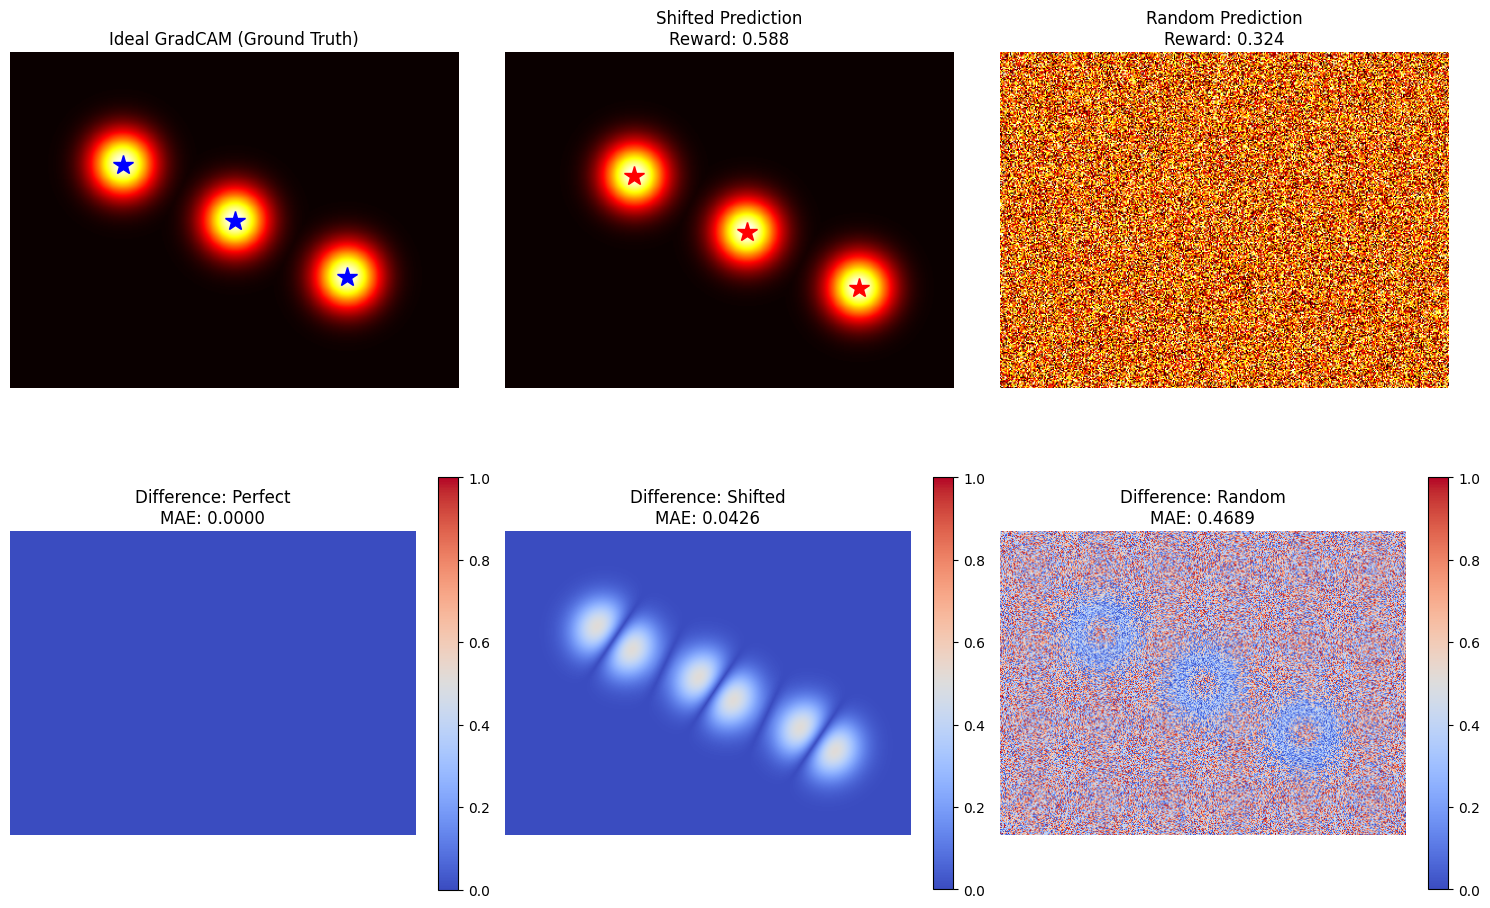

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Ideal GradCAM
axes[0, 0].imshow(ideal_gradcam, cmap='hot')
axes[0, 0].plot([c[0] for c in gt_centroids], [c[1] for c in gt_centroids], 'b*', markersize=15)
axes[0, 0].set_title('Ideal GradCAM (Ground Truth)')
axes[0, 0].axis('off')

axes[0, 1].imshow(predicted_gradcam_shifted, cmap='hot')
axes[0, 1].plot([c[0] for c in shifted_centroids], [c[1] for c in shifted_centroids], 'r*', markersize=15)
axes[0, 1].set_title(f'Shifted Prediction\nReward: {reward_shifted["combined_reward"]:.3f}')
axes[0, 1].axis('off')

axes[0, 2].imshow(predicted_gradcam_random, cmap='hot')
axes[0, 2].set_title(f'Random Prediction\nReward: {reward_random["combined_reward"]:.3f}')
axes[0, 2].axis('off')

# Row 2: Difference maps
diff_perfect = np.abs(predicted_gradcam_perfect - ideal_gradcam)
diff_shifted = np.abs(predicted_gradcam_shifted - ideal_gradcam)
diff_random = np.abs(predicted_gradcam_random - ideal_gradcam)

im1 = axes[1, 0].imshow(diff_perfect, cmap='coolwarm', vmin=0, vmax=1)
axes[1, 0].set_title(f'Difference: Perfect\nMAE: {diff_perfect.mean():.4f}')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)

im2 = axes[1, 1].imshow(diff_shifted, cmap='coolwarm', vmin=0, vmax=1)
axes[1, 1].set_title(f'Difference: Shifted\nMAE: {diff_shifted.mean():.4f}')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)

im3 = axes[1, 2].imshow(diff_random, cmap='coolwarm', vmin=0, vmax=1)
axes[1, 2].set_title(f'Difference: Random\nMAE: {diff_random.mean():.4f}')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)

plt.tight_layout()
plt.show()

## 8. GRPO Integration Template

Template for integrating these reward functions with HuggingFace TRL's GRPO trainer.

In [11]:
# This is a template - not executable without full GRPO setup

from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class CountingRewardConfig:
    """Configuration for counting task reward function."""
    gradcam_weight: float = 0.6
    count_weight: float = 0.4
    gradcam_metric: str = 'ssim'  # 'ssim', 'mse', or 'correlation'
    count_offset: float = 10.0
    gaussian_sigma: float = 20.0


class CountingRewardFunction:
    """Reward function for GRPO fine-tuning on object counting task."""
    
    def __init__(self, config: CountingRewardConfig = None):
        self.config = config or CountingRewardConfig()
    
    def __call__(
        self,
        model_outputs: Dict[str, Any],
        ground_truth: Dict[str, Any]
    ) -> float:
        """
        Compute reward for a single model output.
        
        Args:
            model_outputs: Dictionary containing:
                - 'predicted_count': int
                - 'gradcam': np.ndarray (H, W)
                - 'image_size': Tuple[int, int]
            ground_truth: Dictionary containing:
                - 'count': int
                - 'centroids': List[Tuple[int, int]]
                - 'image_size': Tuple[int, int]
        
        Returns:
            reward: Float reward value
        """
        # Extract data
        predicted_count = model_outputs['predicted_count']
        predicted_gradcam = model_outputs['gradcam']
        
        gt_count = ground_truth['count']
        gt_centroids = ground_truth['centroids']
        image_size = ground_truth['image_size']
        
        # Create ideal GradCAM
        ideal_gradcam = create_ideal_gradcam(
            gt_centroids,
            image_size,
            sigma=self.config.gaussian_sigma
        )
        
        # Compute combined reward
        reward_dict = compute_combined_reward(
            predicted_gradcam,
            ideal_gradcam,
            predicted_count,
            gt_count,
            gradcam_weight=self.config.gradcam_weight,
            count_weight=self.config.count_weight,
            gradcam_metric=self.config.gradcam_metric,
            count_offset=self.config.count_offset
        )
        
        return reward_dict['combined_reward']


# Example usage with TRL GRPO trainer (pseudo-code)
"""
from trl import GRPOConfig, GRPOTrainer

# Initialize reward function
reward_fn = CountingRewardFunction()

# Configure GRPO training
grpo_config = GRPOConfig(
    learning_rate=1e-5,
    batch_size=8,
    num_epochs=3,
    group_size=4,  # Number of responses per prompt for relative comparison
    kl_coef=0.05,  # KL divergence coefficient
)

# Initialize trainer
trainer = GRPOTrainer(
    model=model,
    config=grpo_config,
    reward_fn=reward_fn,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Train
trainer.train()
"""

print("GRPO integration template defined.")
print("\nKey components:")
print("1. CountingRewardConfig - hyperparameters for reward function")
print("2. CountingRewardFunction - callable reward function for GRPO")
print("3. Integration with TRL GRPOTrainer (see commented code)")

GRPO integration template defined.

Key components:
1. CountingRewardConfig - hyperparameters for reward function
2. CountingRewardFunction - callable reward function for GRPO
3. Integration with TRL GRPOTrainer (see commented code)


## 9. Data Preparation for GRPO

Helper functions to prepare FSC147 dataset for GRPO training.

In [12]:
def prepare_fsc147_for_grpo(
    data_root: str,
    split: str = 'train',
    max_samples: int = None
) -> List[Dict[str, Any]]:
    """
    Prepare FSC147 dataset for GRPO training.
    
    Args:
        data_root: Path to FSC147 dataset
        split: Dataset split ('train', 'val', 'test')
        max_samples: Maximum number of samples to load
    
    Returns:
        dataset: List of dictionaries with:
            - 'image': PIL Image
            - 'category': str
            - 'ground_truth': Dict with 'count' and 'centroids'
            - 'prompt': str (text prompt for VLM)
    """
    import json
    import random
    from PIL import Image
    
    # Load dataset information
    split_file = os.path.join(data_root, "Train_Test_Val_FSC_147.json")
    with open(split_file, 'r') as f:
        splits = json.load(f)
    
    annotation_file = os.path.join(data_root, "annotation_FSC147_384.json")
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    classes_file = os.path.join(data_root, "ImageClasses_FSC147.txt")
    image_classes = {}
    with open(classes_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                image_classes[parts[0]] = parts[1]
    
    # Get images for split
    split_images = splits[split]
    if max_samples:
        random.seed(42)
        split_images = random.sample(split_images, min(max_samples, len(split_images)))
    
    # Prepare dataset
    dataset = []
    
    for img_name in split_images:
        if img_name not in annotations:
            continue
        
        # Load image
        img_path = os.path.join(data_root, "images_384_VarV2", img_name)
        if not os.path.exists(img_path):
            continue
        
        image = Image.open(img_path).convert("RGB")
        
        # Get annotations
        ann = annotations[img_name]
        centroids = [(int(p[0]), int(p[1])) for p in ann['points']]
        count = len(centroids)
        category = image_classes.get(img_name, 'objects')
        
        # Create prompt
        prompt = f"Count the number of {category} in this image. Provide only the number."
        
        dataset.append({
            'image': image,
            'category': category,
            'ground_truth': {
                'count': count,
                'centroids': centroids,
                'image_size': image.size
            },
            'prompt': prompt,
            'image_name': img_name
        })
    
    return dataset


# Example: Load a small subset for testing
print("Loading FSC147 dataset for GRPO...")
test_dataset = prepare_fsc147_for_grpo(
    data_root="/media/M2SSD/FSC147",
    split="train",
    max_samples=5
)

print(f"\nLoaded {len(test_dataset)} samples")
print("\nExample sample:")
print(f"  Category: {test_dataset[0]['category']}")
print(f"  Ground truth count: {test_dataset[0]['ground_truth']['count']}")
print(f"  Image size: {test_dataset[0]['ground_truth']['image_size']}")
print(f"  Prompt: {test_dataset[0]['prompt']}")

Loading FSC147 dataset for GRPO...

Loaded 5 samples

Example sample:
  Category: cupcake tray
  Ground truth count: 33
  Image size: (408, 384)
  Prompt: Count the number of cupcake tray in this image. Provide only the number.


## 10. Summary and Next Steps

### What We've Built

✅ **Ideal GradCAM Generation**: Create target attention maps from ground truth centroids with Gaussian dispersion

✅ **GradCAM Extraction**: Extract attention maps from VLM model (template provided)

✅ **Alternative Centroid Matching**: Detect and match centroids using Hungarian algorithm

✅ **Reward Components**:
- GradCAM similarity reward (SSIM, MSE, or correlation)
- Count accuracy reward (inverse distance)
- Combined weighted reward

✅ **GRPO Integration Template**: Ready-to-use template for TRL GRPOTrainer

✅ **Data Preparation**: FSC147 dataset loader for GRPO training

### Next Steps for GRPO Training

1. **Test GradCAM extraction** with actual Qwen3-VL model to ensure hooks work correctly
2. **Tune hyperparameters**:
   - `gaussian_sigma`: Controls spread of ideal attention blobs
   - `gradcam_weight` / `count_weight`: Balance between attention and count
   - `count_offset`: Controls sensitivity to count errors
3. **Setup GRPO trainer** following TRL documentation
4. **Run pilot training** on small subset to validate reward signal
5. **Scale up training** on full FSC147 training set
6. **Evaluate** on validation set using existing evaluation scripts

### Files Created

- `/home/denny-loevlie/Jivko/Sequential_Counter/notebooks/04_GRPO_Fine_Tuning_Setup.ipynb` (this notebook)

### Key Functions

- `create_ideal_gradcam()` - Generate ideal attention maps
- `extract_gradcam_from_vlm()` - Extract model attention
- `compute_gradcam_similarity_reward()` - Attention similarity reward
- `compute_count_accuracy_reward()` - Count accuracy reward
- `compute_combined_reward()` - Combined reward function
- `CountingRewardFunction` - GRPO-compatible reward class
- `prepare_fsc147_for_grpo()` - Dataset preparation